# Jess Model Playground

### Prepare Workspace

In [1]:
# Import system libraries
import os
import sys
import warnings
warnings.filterwarnings("ignore")

# Import data manipulation librariaes
import datetime
import pandas as pd
import numpy as np

# Import statistical libraries
from scipy.stats import boxcox
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap

# Set working directory
os.chdir('/Users/jessicarapson/Documents/GitHub/water-supply-forecast')

### Prepare Model Data

In [313]:
# Load feature data
swann_swe = pd.read_csv(
    'assets/data/additional_sites/swann_swe.csv')
streamflow = pd.read_csv(
    'assets/data/additional_sites/usgs_streamflow.csv')
mjo = pd.read_table(
    'assets/data/teleconnections/mjo.txt', delim_whitespace=True, skiprows=1)
nino = pd.read_table(
    'assets/data/teleconnections/nino_regions_sst.txt', delim_whitespace=True)
oni = pd.read_table(
    'assets/data/teleconnections/oni.txt', delim_whitespace=True)
pdo = pd.read_table(
    'assets/data/teleconnections/pdo.txt', delim_whitespace=True, skiprows=1)
pna = pd.read_table(
    'assets/data/teleconnections/pna.txt', delim_whitespace=True)
soi = pd.read_table(
    'assets/data/teleconnections/soi1.txt', delim_whitespace=True, skiprows=2)
soi_anomoly = pd.read_table(
    'assets/data/teleconnections/soi2.txt',delim_whitespace=True, skiprows=2)
hydrobasins = pd.read_csv(
    'assets/data/additional_sites/hydrobasins_summary.csv')
meta_all = pd.read_csv(
    'assets/data/additional_sites/metadata.csv')

# Load outcome data
monthly_flow = pd.read_csv(
    'assets/data/additional_sites/train_monthly_naturalized_flow.csv')
monthly_flow = monthly_flow.rename(columns={'volume': 'volume_month'})
gt_target_sites = pd.read_csv('assets/data/train.csv')

# Load submission data
submission = pd.read_csv('assets/data/submission_format.csv')

# Convert NRCS ids to site ids
meta_all['site_id_new'] = meta_all['nrcs_name'].str.lower().str.replace(
    ' ', '_').str.replace(',', '')
id_dict = dict(zip(meta_all['site_id_new'], meta_all['site_id']))
streamflow['site_id'] = streamflow['site_id'].replace(id_dict)

# Identify unique site and date values
all_sites = meta_all['site_id'].unique()
valid_days = [1, 8, 15, 22]
min_date = min(streamflow['week_start_date'])
max_date = max(streamflow['week_start_date'])
all_dates = pd.to_datetime(
    [date for date in pd.date_range(min_date, max_date).tolist()
     if date.day in valid_days])

# Create site and date dataframe for linking predictor data
df_base = pd.DataFrame(columns=['site_id', 'date'])
df_base['site_id'] = [site_id for site_id in all_sites for _ in range(len(all_dates))]
df_base['date'] = all_dates.tolist() * len(all_sites)

# Extract year, month, and day from base data
df_base['year'] = pd.to_datetime(df_base['date']).dt.year
df_base['month'] = pd.to_datetime(df_base['date']).dt.month
df_base['dayofyear'] = pd.to_datetime(df_base['date']).dt.dayofyear

# Function to round date_reported to the nearest date in all_dates
def round_to_nearest_date(date, all_dates):
    nearest_date = min(all_dates, key=lambda x: abs(x - date))
    return nearest_date

# Join SWANN data on site id and subsequent week
cols = ['site_id', 'join_date', 'SWE_depth_m', 'SWE_depth_m_AREA_SCALED']
swann_swe['week_start_date'] = pd.to_datetime(swann_swe['week_start_date'])
date_indices = [np.where(all_dates == date)[0][0] if
                date in all_dates else -1 for date in swann_swe['week_start_date']]
next_dates = [all_dates[min(index + 1, len(all_dates) - 1)] if
              index != -1 else pd.NaT for index in date_indices]
swann_swe['join_date'] = next_dates
df_linked = df_base.merge(swann_swe[cols], how='left',
                          left_on=['site_id', 'date'], right_on=['site_id', 'join_date'])
df_linked = df_linked.drop('join_date', axis=1)

# Join SWANN data for April 1st on subsequent week
swann_apr1 = swann_swe[swann_swe['week_start_date'].astype(str).str[-5:] == '04-01']
swann_apr1 = swann_apr1.rename(columns={
    'SWE_depth_m': 'SWE_depth_m_apr1',
    'SWE_depth_m_AREA_SCALED': 'SWE_depth_m_AREA_SCALED_apr1'})
cols = ['site_id', 'join_date', 'SWE_depth_m_apr1', 'SWE_depth_m_AREA_SCALED_apr1']
df_linked = df_linked.merge(swann_apr1[cols], how='left', left_on=['site_id', 'date'],
                  right_on=['site_id', 'join_date'])
df_linked = df_linked.drop('join_date', axis=1)

# Join streamflow data on site id and subsequent week
cols = ['site_id', 'join_date', '00060_Mean']
streamflow['week_start_date'] = pd.to_datetime(streamflow['week_start_date'])
date_indices = [np.where(all_dates == date)[0][0] if
                date in all_dates else -1 for date in streamflow['week_start_date']]
next_dates = [all_dates[min(index + 1, len(all_dates) - 1)] if
              index != -1 else pd.NaT for index in date_indices]
streamflow['join_date'] = next_dates
df_linked = df_linked.merge(streamflow[cols], how='left',
                          left_on=['site_id', 'date'], right_on=['site_id', 'join_date'])
df_linked = df_linked.drop('join_date', axis=1)

# Join monthly flows on site id and subsequent month
cols = ['site_id', 'join_year', 'join_month', 'volume_month']
monthly_flow['join_month'] = monthly_flow['month'] + 1
monthly_flow['join_year'] =  np.where(
    monthly_flow['join_month'] == 13, monthly_flow['year'] + 1, monthly_flow['year'])
monthly_flow['join_month'] = np.where(
    monthly_flow['join_month'] == 13, 1, monthly_flow['join_month'])
df_linked = df_linked.merge(monthly_flow[cols], how='left', left_on=['site_id', 'year', 'month'],
                right_on=['site_id', 'join_year', 'join_month'])
df_linked = df_linked.drop(['join_year', 'join_month'], axis=1)

# Clean MJO data and join on subsequent five days
mjo = mjo.replace('*****', np.nan)
mjo['date'] = pd.to_datetime(mjo['PENTAD'], format='%Y%m%d')
mjo['date_reported'] = mjo['date'] + pd.to_timedelta(5, unit='d')
mjo = mjo[mjo['date'] >= all_dates.min()]
mjo['date_join'] = mjo['date_reported'].apply(lambda x: round_to_nearest_date(x, all_dates))
mjo = mjo.drop(['PENTAD', 'date', 'date_reported'], axis=1)
mjo[mjo.columns[:-1]] = mjo[mjo.columns[:-1]].astype(float)
mjo = mjo.groupby('date_join').mean().reset_index()
df_linked = df_linked.merge(mjo, how='left', left_on='date', right_on='date_join')
df_linked = df_linked.drop(['date_join'], axis=1)

# Clean Nino Regions SST data and join on subsequent month
nino['join_month'] = nino['MON'] + 1
nino['join_year'] =  np.where(
    nino['join_month'] == 13, nino['YR'] + 1, nino['YR'])
nino['join_month'] = np.where(
    nino['join_month'] == 13, 1, nino['join_month'])
cols_drop = ['YR', 'MON']
df_linked = df_linked.merge(nino.drop(cols_drop, axis=1), how='left',
              left_on=['year', 'month'], right_on=['join_year', 'join_month'])
df_linked = df_linked.drop(['join_year', 'join_month'], axis=1)

# Clean ONI data and join on subsequent month
month_to_join = {
    'OND': 1, 'NDJ': 2, 'DJF': 3, 'JFM': 4, 'FMA': 5, 'MAM': 6,
    'AMJ': 7, 'MJJ': 8, 'JJA': 9, 'JAS': 10, 'ASO': 11, 'SON': 12}
oni['join_month'] = oni['SEAS'].replace(month_to_join)
oni['join_year'] = np.where(oni['SEAS'].isin(['OND', 'NDJ']), oni['YR'] + 1, oni['YR'])
cols = ['join_year', 'join_month', 'TOTAL', 'ANOM']
df_linked = df_linked.merge(oni[cols], how='left', left_on=['year', 'month'],
                right_on=['join_year', 'join_month'])
df_linked = df_linked.drop(['join_year', 'join_month'], axis=1)

# Clean PDO data and join on subsequent month
pdo = pd.melt(pdo, id_vars=['Year'], var_name='month', value_name='pdo')
pdo['pdo'] = pdo['pdo'].replace(99.99, np.nan)
month_to_num = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
pdo['month'] = pdo['month'].replace(month_to_num)
pdo['join_month'] = pdo['month'] + 1
pdo['join_year'] =  np.where(
    pdo['join_month'] == 13, pdo['Year'] + 1, pdo['Year'])
pdo['join_month'] = np.where(
    pdo['join_month'] == 13, 1, pdo['join_month'])
cols = ['join_year', 'join_month', 'pdo']
df_linked = df_linked.merge(pdo[cols], how='left', left_on=['year', 'month'],
                right_on=['join_year', 'join_month'])
df_linked = df_linked.drop(['join_year', 'join_month'], axis=1)

# Clean PNA data and join on subsequent month
pna = pd.melt(pna, id_vars=['year'], var_name='month', value_name='pna')
pna['pna'] = pna['pna'].replace(99.99, np.nan)
month_to_num = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
pna['month'] = pna['month'].replace(month_to_num)
pna['join_month'] = pna['month'] + 1
pna['join_year'] =  np.where(
    pna['join_month'] == 13, pna['year'] + 1, pna['year'])
pna['join_month'] = np.where(
    pna['join_month'] == 13, 1, pna['join_month'])
cols = ['join_year', 'join_month', 'pna']
df_linked = df_linked.merge(pna[cols], how='left', left_on=['year', 'month'],
                right_on=['join_year', 'join_month'])
df_linked = df_linked.drop(['join_year', 'join_month'], axis=1)

# Clean SOI data and join on subsequent month
soi = pd.melt(soi, id_vars=['YEAR'], var_name='month', value_name='soi')
soi['soi'] = soi['soi'].replace(99.99, np.nan)
month_to_num = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
soi['month'] = soi['month'].str.title().replace(month_to_num)
soi['join_month'] = soi['month'] + 1
soi['join_year'] =  np.where(
    soi['join_month'] == 13, soi['YEAR'] + 1, soi['YEAR'])
soi['join_month'] = np.where(
    soi['join_month'] == 13, 1, soi['join_month'])
cols = ['join_year', 'join_month', 'soi']
df_linked = df_linked.merge(soi[cols], how='left', left_on=['year', 'month'],
                right_on=['join_year', 'join_month'])
df_linked = df_linked.drop(['join_year', 'join_month'], axis=1)

# Clean SOI anomoly data and join on subsequent month
soi_anomoly = pd.melt(soi_anomoly, id_vars=['YEAR'], var_name='month', value_name='soi_anomoly')
soi_anomoly['soi_anomoly'] = soi_anomoly['soi_anomoly'].replace(99.99, np.nan)
month_to_num = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
soi_anomoly['month'] = soi_anomoly['month'].str.title().replace(month_to_num)
soi_anomoly['join_month'] = soi_anomoly['month'] + 1
soi_anomoly['join_year'] =  np.where(
    soi_anomoly['join_month'] == 13, soi_anomoly['YEAR'] + 1, soi_anomoly['YEAR'])
soi_anomoly['join_month'] = np.where(
    soi_anomoly['join_month'] == 13, 1, soi_anomoly['join_month'])
cols = ['join_year', 'join_month', 'soi_anomoly']
df_linked = df_linked.merge(soi_anomoly[cols], how='left', left_on=['year', 'month'],
                right_on=['join_year', 'join_month'])
df_linked = df_linked.drop(['join_year', 'join_month'], axis=1)

# Join hydrobasins on site
df_linked = df_linked.merge(hydrobasins, how='left', on='site_id')

# Join metadata on site
meta_all['season_length'] = 1 + meta_all['season_end_month'] - meta_all['season_start_month']
cols = ['site_id', 'elevation', 'latitude', 'longitude', 'season_length']
df_linked = df_linked.merge(meta_all[cols], how='left', on='site_id')

# Get list of target sites and dates
sites_target = submission['site_id'].unique()
dates_target = submission['issue_date'].unique()

# Create flag for target sites
df_linked['is_target_site'] = df_linked['site_id'].isin(sites_target)
df_linked['is_target_date'] = df_linked['date'].isin(dates_target)

# Filter to forecasting period
df_input = df_linked[df_linked['month'] <= 7]

# Calculate seasonal ground truth data by summing April to July
gt_new_sites = monthly_flow[monthly_flow['month'].isin([4,5,6,7])].groupby(
    ['site_id', 'forecast_year'])['volume_month'].sum().reset_index()
gt_new_sites = gt_new_sites.rename(columns={'volume_month': 'volume'})

# Link ground truth data
data_gt_target = pd.merge(
    df_input[df_input['is_target_site'] == True], gt_target_sites,
    how='left', on=['site_id', 'year'])
data_gt_new = pd.merge(
    df_input[df_input['is_target_site'] == False], gt_new_sites,
    how='left', left_on=['site_id', 'year'], right_on=['site_id', 'forecast_year'])
df = pd.concat([data_gt_target, data_gt_new]).drop('forecast_year', axis=1)

# One hot encode categorical values
cat_vals = ['clz_cl_smj', 'cls_cl_smj', 'glc_cl_smj', 'pnv_cl_smj', 'wet_cl_smj',
            'tbi_cl_smj', 'tec_cl_smj', 'fmh_cl_smj', 'fec_cl_smj', 'lit_cl_smj']
df[cat_vals] = df[cat_vals].astype(str)
one_hot_encoded = pd.get_dummies(df[cat_vals])
df = pd.concat([df, one_hot_encoded], axis=1)
df = df.drop(cat_vals, axis=1)

In [314]:
df

,site_id,date,year,month,dayofyear,SWE_depth_m,SWE_depth_m_AREA_SCALED,SWE_depth_m_apr1,SWE_depth_m_AREA_SCALED_apr1,00060_Mean,...,lit_cl_smj_10,lit_cl_smj_11,lit_cl_smj_12,lit_cl_smj_2,lit_cl_smj_3,lit_cl_smj_5,lit_cl_smj_6,lit_cl_smj_7,lit_cl_smj_8,lit_cl_smj_9
0,hungry_horse_reservoir_inflow,1985-01-01,1985,1,1,0.215797,5048.645661,NaN,NaN,6742.000000,...,False,False,False,False,True,False,False,False,False,False
1,hungry_horse_reservoir_inflow,1985-01-08,1985,1,8,0.243272,5691.431415,NaN,NaN,5787.142857,...,False,False,False,False,True,False,False,False,False,False
2,hungry_horse_reservoir_inflow,1985-01-15,1985,1,15,0.242152,5665.211299,NaN,NaN,4985.714286,...,False,False,False,False,True,False,False,False,False,False
3,hungry_horse_reservoir_inflow,1985-01-22,1985,1,22,0.247122,5781.500880,NaN,NaN,5242.857143,...,False,False,False,False,True,False,False,False,False,False
4,hungry_horse_reservoir_inflow,1985-02-01,1985,2,32,0.246038,5756.130973,NaN,NaN,8637.000000,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646459,09386950:NM:USGS,2023-06-22,2023,6,173,NaN,NaN,NaN,NaN,0.000000,...,False,False,False,False,True,False,False,False,False,False
646460,09386950:NM:USGS,2023-07-01,2023,7,182,NaN,NaN,NaN,NaN,0.000000,...,False,False,False,False,True,False,False,False,False,False
646461,09386950:NM:USGS,2023-07-08,2023,7,189,NaN,NaN,NaN,NaN,0.000000,...,False,False,False,False,True,False,False,False,False,False
646462,09386950:NM:USGS,2023-07-15,2023,7,196,NaN,NaN,NaN,NaN,0.000000,...,False,False,False,False,True,False,False,False,False,False


### Build Models for My Data

#### *Loss Function* ####

In [34]:
# Define a function to compute quantile loss for a single quantile
def quantile_loss(y_true, y_pred, q):
    residual = y_true - y_pred
    return np.mean(2 * np.maximum(q * residual, (q - 1) * residual))

# Set quantiles
quantiles = [0.1, 0.5, 0.9]

#### *XGBoost, No Train-Test Split, All Data*

In [184]:
# Generating data
cols_drop = ['site_id', 'date', 'year', 'is_target_site', 'is_target_date', 'volume']
data = df.dropna(subset=['volume'])
X, y = data.drop(cols_drop, axis=1), data['volume']

# Train XGBoost model to predict both mean and variance
model_mean = xgb.XGBRegressor(objective='reg:squarederror')
model_var = xgb.XGBRegressor(objective='reg:squarederror')

model_mean.fit(X, y)
predicted_mean = model_mean.predict(X)

# Calculate residuals (difference between actual and predicted mean)
residuals = y - predicted_mean

model_var.fit(X, residuals**2)  # Train to predict the variance (squared residuals)

# Predict variance
predicted_var = model_var.predict(X)

# Obtain predicted standard deviation by taking the square root of the predicted variance
predicted_std = np.sqrt(np.clip(predicted_var, a_min=0, a_max=None))

# Calculate quantiles based on predicted mean and standard deviation
quantile_10th = predicted_mean - 1.28 * predicted_std  # 10th percentile (assuming normal distribution)
quantile_50th = predicted_mean
quantile_90th = predicted_mean + 1.28 * predicted_std  # 90th percentile (assuming normal distribution)

# Display calculated quantiles
print(f"10th percentile: {quantile_10th}")
print(f"50th percentile: {quantile_50th}")
print(f"90th percentile: {quantile_90th}")

# Calculate quantile loss
average_mean_quantile_loss = np.mean([
    quantile_loss(y, np.clip(quantile_10th, a_min=0, a_max=None), quantiles[0]),
    quantile_loss(y, np.clip(quantile_50th, a_min=0, a_max=None), quantiles[1]),
    quantile_loss(y, np.clip(quantile_90th, a_min=0, a_max=None), quantiles[2])
    ])
print("\nAverage Mean Quantile Loss:", average_mean_quantile_loss)

10th percentile: [1831.7325  1712.1257  1718.2777  ...  -19.32896  -19.32896  -19.32896]
50th percentile: [2297.3115  2177.763   2177.763   ...  -19.32896  -19.32896  -19.32896]
90th percentile: [2762.8906  2643.4001  2637.2483  ...  -19.32896  -19.32896  -19.32896]
Average Mean Quantile Loss: 70.34500670311223


#### *XGBoost, Train-Test Split, All Data*

In [185]:
# Generating data
cols_drop = ['site_id', 'date', 'year', 'is_target_site', 'is_target_date', 'volume']
data = df.dropna(subset=['volume'])
X, y = data.drop(cols_drop, axis=1), data['volume']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Train XGBoost model to predict both mean and variance
model_mean = xgb.XGBRegressor(objective='reg:squarederror')
model_var = xgb.XGBRegressor(objective='reg:squarederror')

model_mean.fit(X_train, y_train)
predicted_mean = model_mean.predict(X_train)

# Calculate residuals (difference between actual and predicted mean)
residuals = y_train - predicted_mean

model_var.fit(X_train, residuals**2)  # Train to predict the variance (squared residuals)

# Predict variance
predicted_var = model_var.predict(X_test)
predicted_mean = model_mean.predict(X_test)

# Obtain predicted standard deviation by taking the square root of the predicted variance
predicted_std = np.sqrt(np.clip(predicted_var, a_min=0, a_max=None))

# Calculate quantiles based on predicted mean and standard deviation
quantile_10th = predicted_mean - 1.28 * predicted_std  # For example, 10th percentile (assuming normal distribution)
quantile_50th = predicted_mean
quantile_90th = predicted_mean + 1.28 * predicted_std  # For example, 90th percentile (assuming normal distribution)

# Display calculated quantiles
print(f"10th percentile: {quantile_10th}")
print(f"50th percentile: {quantile_50th}")
print(f"90th percentile: {quantile_90th}")

# Calculate quantile loss
average_mean_quantile_loss = np.mean([
    quantile_loss(y_test, np.clip(quantile_10th, a_min=0, a_max=None), quantiles[0]),
    quantile_loss(y_test, np.clip(quantile_50th, a_min=0, a_max=None), quantiles[1]),
    quantile_loss(y_test, np.clip(quantile_90th, a_min=0, a_max=None), quantiles[2])
    ])
print("\nAverage Mean Quantile Loss:", average_mean_quantile_loss)

10th percentile: [ -81.45253   -31.936592  136.24925  ...  -71.65061  5224.861
  600.3611  ]
50th percentile: [  17.658108   112.86561    309.71323   ...    7.8088827 6212.3423
  991.9493   ]
90th percentile: [ 116.76874  257.66782  483.1772  ...   87.26838 7199.8237  1383.5375 ]
Average Mean Quantile Loss: 78.98516007441292


#### *XGBoost, Train-Test Split, Target Data*

In [186]:
# Extract data from target sites only
cols_drop = ['site_id', 'date', 'year', 'is_target_site', 'is_target_date', 'volume']
data = df.dropna(subset=['volume'])
data = data[data['is_target_site']]
X, y = data.drop(cols_drop, axis=1), data['volume']

# Predict variance
predicted_var = model_var.predict(X)
predicted_mean = model_mean.predict(X)

# Obtain predicted standard deviation by taking the square root of the predicted variance
predicted_std = np.sqrt(np.clip(predicted_var, a_min=0, a_max=None))

# Calculate quantiles based on predicted mean and standard deviation
quantile_10th = predicted_mean - 1.28 * predicted_std  # 10th percentile (assuming normal distribution)
quantile_50th = predicted_mean
quantile_90th = predicted_mean + 1.28 * predicted_std  # 90th percentile (assuming normal distribution)

# Display calculated quantiles
print(f"10th percentile: {quantile_10th}")
print(f"50th percentile: {quantile_50th}")
print(f"90th percentile: {quantile_90th}")

average_mean_quantile_loss = np.mean([
    quantile_loss(y, np.clip(quantile_10th, a_min=0, a_max=None), quantiles[0]),
    quantile_loss(y, np.clip(quantile_50th, a_min=0, a_max=None), quantiles[1]),
    quantile_loss(y, np.clip(quantile_90th, a_min=0, a_max=None), quantiles[2])
    ])
print("\nAverage Mean Quantile Loss:", average_mean_quantile_loss)

10th percentile: [1747.2993  1814.8378  1857.2166  ...  -58.20161  -60.45565  -67.87582]
50th percentile: [2148.7227   2227.8545   2254.3557   ...   27.44775    28.131508
   28.131508]
90th percentile: [2550.146    2640.871    2651.4949   ...  113.09711   116.718666
  124.13883 ]

Average Mean Quantile Loss: 115.47775776502124


#### *Shapley Values*

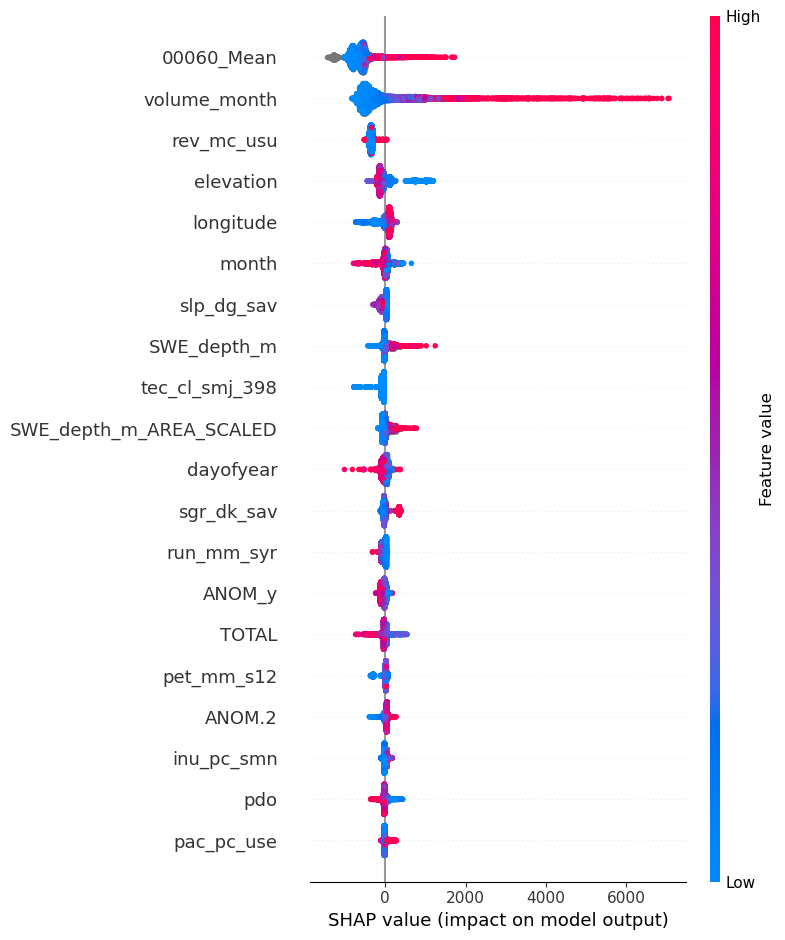

In [214]:
# Ensure boolean values are numeric
bool_cols = X_train.select_dtypes(include='bool').columns.tolist()
X_train[bool_cols] = X_train[bool_cols].fillna(False).astype(int)

# # Extract Shapley values
explainer = shap.Explainer(model_mean, X_train)
shap_values_mean = explainer.shap_values(X)

# Summary plot of SHAP values
shap.summary_plot(shap_values_mean, X)

### Build Models for Output Data

In [46]:
# Generating data
ids = ['site_id', 'date', 'volume', 'forecast_year']
data = df.dropna(subset=['volume'])
X, y = data.drop(ids, axis=1), data['volume']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)  # 'reg:squarederror' for regression

# Fitting the model
xg_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = xg_reg.predict(X_test)

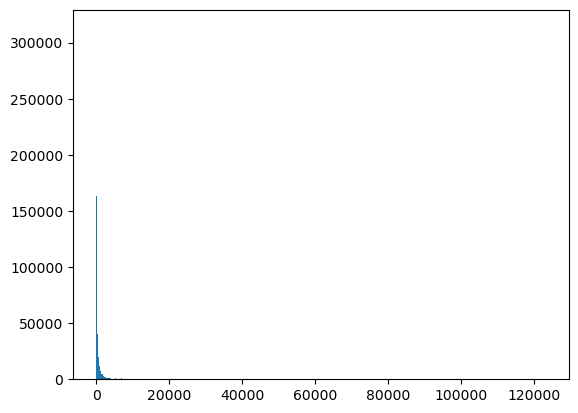

In [47]:
plt.hist(y, bins=1000)
plt.show()

#### *XGBoost, No Scaling, All Data*

In [88]:
# Generating data
ids = ['site_id', 'date', 'volume', 'forecast_year']
data = df.dropna(subset=['volume'])
X, y = data.drop(ids, axis=1), data['volume']

# Train XGBoost model to predict both mean and variance
model_mean = xgb.XGBRegressor(objective='reg:squarederror')
model_var = xgb.XGBRegressor(objective='reg:squarederror')

model_mean.fit(X, y)
predicted_mean = model_mean.predict(X)

# Calculate residuals (difference between actual and predicted mean)
residuals = y - predicted_mean

model_var.fit(X, residuals**2)  # Train to predict the variance (squared residuals)

# Predict variance
predicted_var = model_var.predict(X)

# Obtain predicted standard deviation by taking the square root of the predicted variance
predicted_std = np.sqrt(np.clip(predicted_var, a_min=0, a_max=None))

# Calculate quantiles based on predicted mean and standard deviation
quantile_10th = predicted_mean - 1.28 * predicted_std  # For example, 10th percentile (assuming normal distribution)
quantile_50th = predicted_mean
quantile_90th = predicted_mean + 1.28 * predicted_std  # For example, 90th percentile (assuming normal distribution)

# Display calculated quantiles
print(f"10th percentile: {quantile_10th}")
print(f"50th percentile: {quantile_50th}")
print(f"90th percentile: {quantile_90th}")

10th percentile: [-25.501717 -25.501717 -25.501717 ...        nan        nan        nan]
50th percentile: [86.9654   86.9654   86.9654   ...  2.651667  2.651667  2.651667]
90th percentile: [199.43253 199.43253 199.43253 ...       nan       nan       nan]


In [117]:
average_mean_quantile_loss = np.mean([
    quantile_loss(y, np.clip(quantile_10th, a_min=0, a_max=None), quantiles[0]),
    quantile_loss(y, np.clip(quantile_50th, a_min=0, a_max=None), quantiles[1]),
    quantile_loss(y, np.clip(quantile_90th, a_min=0, a_max=None), quantiles[2])
    ])
print("Average Mean Quantile Loss:", average_mean_quantile_loss)

Average Mean Quantile Loss: 111.54280178882776


In [ ]:
# SHAP explainer for the mean model
explainer_mean = shap.Explainer(model_mean, X)
shap_values_mean = explainer_mean.shap_values(X)

# Summary plot of SHAP values
shap.summary_plot(shap_values_mean, X)

#### *XGBoost, No Scaling, Train-Test Split*

In [440]:
# Generating data
ids = ['site_id', 'date', 'volume', 'forecast_year']
data = df.dropna(subset=['volume'])
X, y = data.drop(ids, axis=1), data['volume']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Train XGBoost model to predict both mean and variance
model_mean = xgb.XGBRegressor(objective='reg:squarederror')
model_var = xgb.XGBRegressor(objective='reg:squarederror')

model_mean.fit(X_train, y_train)
predicted_mean = model_mean.predict(X_train)

# Calculate residuals (difference between actual and predicted mean)
residuals = y_train - predicted_mean

model_var.fit(X_train, residuals**2)  # Train to predict the variance (squared residuals)

# Predict variance
predicted_var = model_var.predict(X_test)
predicted_mean = model_mean.predict(X_test)

# Obtain predicted standard deviation by taking the square root of the predicted variance
predicted_std = np.sqrt(np.clip(predicted_var, a_min=0, a_max=None))

# Calculate quantiles based on predicted mean and standard deviation
quantile_10th = predicted_mean - 1.28 * predicted_std  # For example, 10th percentile (assuming normal distribution)
quantile_50th = predicted_mean
quantile_90th = predicted_mean + 1.28 * predicted_std  # For example, 90th percentile (assuming normal distribution)

# Display calculated quantiles
print(f"10th percentile: {quantile_10th}")
print(f"50th percentile: {quantile_50th}")
print(f"90th percentile: {quantile_90th}")

10th percentile: [ 290.26315   5008.6553     611.6979    ...  -29.51622    -13.3836975
  -22.906563 ]
50th percentile: [ 463.19592  5930.881     836.3156   ...   20.995865  217.81665
   79.484566]
90th percentile: [ 636.12866 6853.1064  1060.9333  ...   71.50795  449.017    181.8757 ]


In [443]:
average_mean_quantile_loss = np.mean([
    quantile_loss(y_test, np.clip(quantile_10th, a_min=0, a_max=None), quantiles[0]),
    quantile_loss(y_test, np.clip(quantile_50th, a_min=0, a_max=None), quantiles[1]),
    quantile_loss(y_test, np.clip(quantile_90th, a_min=0, a_max=None), quantiles[2])
    ])
print("Average Mean Quantile Loss:", average_mean_quantile_loss)

Average Mean Quantile Loss: 118.75942177272067


In [444]:
# Extract data from target sites only
ids = ['site_id', 'date', 'volume', 'forecast_year']
data = df.dropna(subset=['volume'])
data = data[data['site_id'].isin(sites)]
X, y = data.drop(ids, axis=1), data['volume']

# Predict variance
predicted_var = model_var.predict(X)
predicted_mean = model_mean.predict(X)

# Obtain predicted standard deviation by taking the square root of the predicted variance
predicted_std = np.sqrt(np.clip(predicted_var, a_min=0, a_max=None))

# Calculate quantiles based on predicted mean and standard deviation
quantile_10th = predicted_mean - 1.28 * predicted_std  # For example, 10th percentile (assuming normal distribution)
quantile_50th = predicted_mean
quantile_90th = predicted_mean + 1.28 * predicted_std  # For example, 90th percentile (assuming normal distribution)

average_mean_quantile_loss = np.mean([
    quantile_loss(y, np.clip(quantile_10th, a_min=0, a_max=None), quantiles[0]),
    quantile_loss(y, np.clip(quantile_50th, a_min=0, a_max=None), quantiles[1]),
    quantile_loss(y, np.clip(quantile_90th, a_min=0, a_max=None), quantiles[2])
    ])
print("Average Mean Quantile Loss:", average_mean_quantile_loss)

Average Mean Quantile Loss: 182.81958208653177


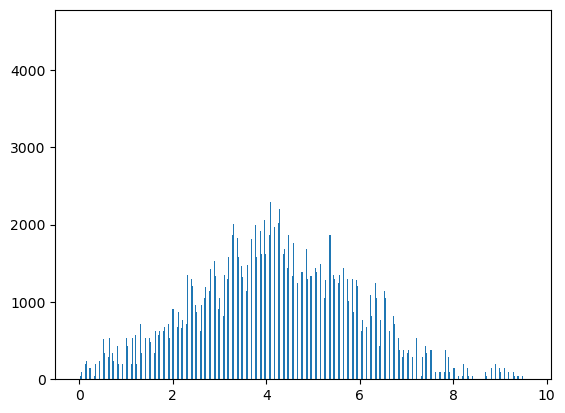

In [56]:
plt.hist(boxcox(y.clip(lower=0) + 1), bins=1000)
plt.show()

In [ ]:
# Apply Box-Cox transformation to normalize the output variable
y_transformed, lambda_value = boxcox(y.clip(lower=0) + 1)  # Adding 1 to avoid zero values

# Train XGBoost model to predict both mean and variance
model_mean = xgb.XGBRegressor(objective='reg:squarederror')
model_var = xgb.XGBRegressor(objective='reg:squarederror')

model_mean.fit(X, y_transformed)
predicted_mean_transformed = model_mean.predict(X)

# Calculate residuals (difference between actual and predicted mean)
residuals = y_transformed - predicted_mean_transformed

model_var.fit(X, residuals**2)  # Train to predict the variance (squared residuals)

# Predict mean and variance
predicted_mean = np.power((predicted_mean_transformed * lambda_value) + 1, 1 / lambda_value)
predicted_var = model_var.predict(X)

# Obtain predicted standard deviation by taking the square root of the predicted variance
predicted_std = np.sqrt(predicted_var)

# Calculate quantiles based on predicted mean and standard deviation
quantile_10th = predicted_mean - 1.28 * predicted_std  # For example, 10th percentile (assuming normal distribution)
quantile_50th = predicted_mean
quantile_90th = predicted_mean + 1.28 * predicted_std  # For example, 90th percentile (assuming normal distribution)

In [86]:
average_mean_quantile_loss = np.mean([
    quantile_loss(y, quantile_10th, quantiles[0]),
    quantile_loss(y, quantile_50th, quantiles[1]),
    quantile_loss(y, quantile_90th, quantiles[2])
    ])
print("Average Mean Quantile Loss:", average_mean_quantile_loss)

Average Mean Quantile Loss: 217.03468522685145


### Conduct Error Analysis

In [5]:
# Import predictions
final_val = pd.read_csv('models/calibration_data/final_val.csv')
val_gt = pd.read_csv('models/calibration_data/val_gt.csv')

# Define a function to compute quantile loss for a single quantile
def quantile_loss(y_true, y_pred, q):
    residual = y_true - y_pred
    return np.mean(2 * np.maximum(q * residual, (q - 1) * residual))

# Calculate loss per site
sites = final_val['site_id'].unique()
loss = {key: None for key in sites}
for i in sites:
    X = final_val[final_val['site_id'] == i]
    y = val_gt[val_gt['site_id'] == i]
    quantiles = [0.1, 0.5, 0.9]
    predictions_10th = X['volume_10']
    predictions_50th = X['volume_50']
    predictions_90th = X['volume_90']
    ground_truth = y['volume']
    # Calculate average mean quantile loss across quantiles of interest
    average_mean_quantile_loss = np.mean([
    quantile_loss(ground_truth, predictions_10th, quantiles[0]),
    quantile_loss(ground_truth, predictions_50th, quantiles[1]),
    quantile_loss(ground_truth, predictions_90th, quantiles[2])
    ])
    loss[i] = average_mean_quantile_loss
pd.DataFrame(list(loss.items()), columns=['Site', 'Loss']).sort_values(by="Loss", ascending=False)

,Site,Loss
1,snake_r_nr_heise,397.912837
7,libby_reservoir_inflow,355.553530
17,american_river_folsom_lake,320.309016
4,missouri_r_at_toston,281.097933
15,san_joaquin_river_millerton_reservoir,201.853447
0,hungry_horse_reservoir_inflow,195.603808
6,yampa_r_nr_maybell,145.071474
23,boysen_reservoir_inflow,129.166283
13,fontenelle_reservoir_inflow,121.143753
8,boise_r_nr_boise,119.200140


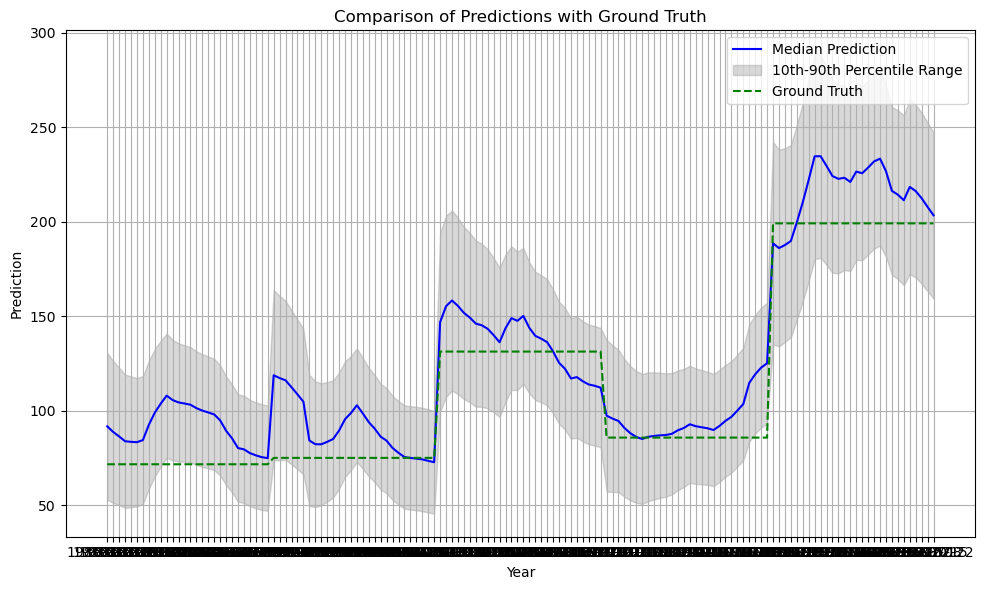

In [15]:
import matplotlib.pyplot as plt

# Assuming final_val and val_gt are your DataFrames containing the series
# final_val['volume_10'], final_val['volume_50'], final_val['volume_90'], val_gt['volume'] are Series
# Example data:
X = final_val[final_val['site_id'] == 'colville_r_at_kettle_falls']
y = val_gt[val_gt['site_id'] == 'colville_r_at_kettle_falls']

# Replace these with your actual series
predictions_10th = X['volume_10']
predictions_50th = X['volume_50']
predictions_90th = X['volume_90']
ground_truth = y['volume']

# Assuming years are present in your DataFrame as an index or as a separate column
years = X['issue_date']  # Change this based on your actual data

# Plotting
plt.figure(figsize=(10, 6))

# Plot median (50th percentile) predictions
plt.plot(years, predictions_50th, label='Median Prediction', color='blue')

# Plotting the 10th and 90th percentile bounds as error bars or shaded area
plt.fill_between(years, predictions_10th, predictions_90th, color='gray', alpha=0.3, label='10th-90th Percentile Range')

# Plotting the ground truth
plt.plot(years, ground_truth, label='Ground Truth', color='green', linestyle='--')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Prediction')
plt.title('Comparison of Predictions with Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

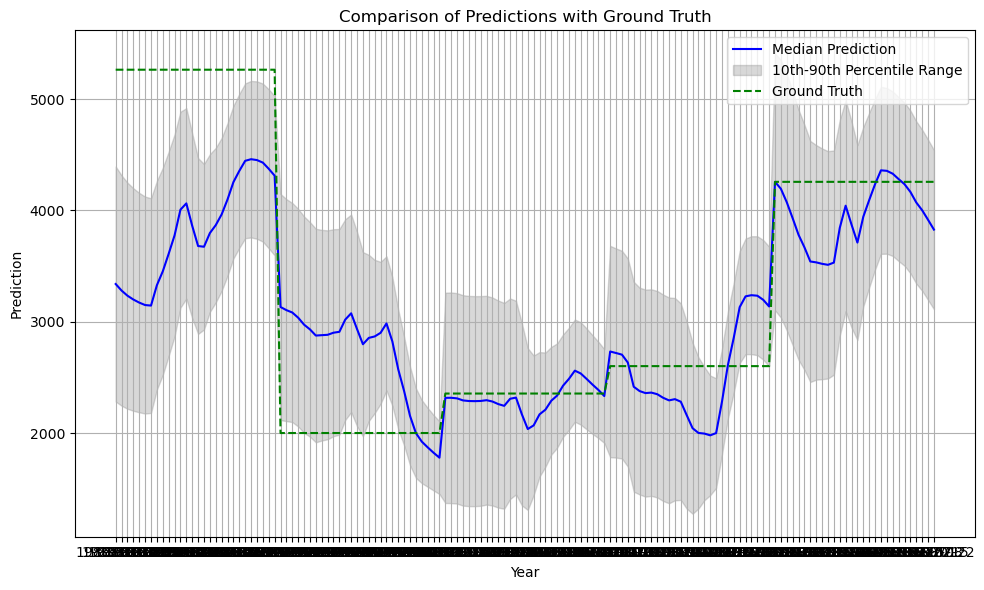

In [16]:
import matplotlib.pyplot as plt

# Assuming final_val and val_gt are your DataFrames containing the series
# final_val['volume_10'], final_val['volume_50'], final_val['volume_90'], val_gt['volume'] are Series
# Example data:
X = final_val[final_val['site_id'] == 'snake_r_nr_heise']
y = val_gt[val_gt['site_id'] == 'snake_r_nr_heise']

# Replace these with your actual series
predictions_10th = X['volume_10']
predictions_50th = X['volume_50']
predictions_90th = X['volume_90']
ground_truth = y['volume']

# Assuming years are present in your DataFrame as an index or as a separate column
years = X['issue_date']  # Change this based on your actual data

# Plotting
plt.figure(figsize=(10, 6))

# Plot median (50th percentile) predictions
plt.plot(years, predictions_50th, label='Median Prediction', color='blue')

# Plotting the 10th and 90th percentile bounds as error bars or shaded area
plt.fill_between(years, predictions_10th, predictions_90th, color='gray', alpha=0.3, label='10th-90th Percentile Range')

# Plotting the ground truth
plt.plot(years, ground_truth, label='Ground Truth', color='green', linestyle='--')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Prediction')
plt.title('Comparison of Predictions with Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:

# Create column for April 1st values
# Impute missing values
# Test delta model

# Train using cross validation
# Train site-specific models



# Impute missing data for american folstrom late
# Add legal past year data

# Try quantile loss

# Test new SNOTEL and CDEC data
# Test using old predictors (with original polygon) for target data
